# Toxic Comments Challenge:
#### By Andreas Nielsen, Aidan Huerta, and Drew Levy
-------



## First lets load and explore the data that we will be using.
For the competition this data set came from the goal of the model is to differentiate between different types of toxic comments from Wikipedia including threats, obscenity, insults, and identity-based hate. If we can detect the difference between these types of toxic comments, websites can use a model such as this to remove types of speech that do not align with their intended use of their services and remove comments that contain hate-speech from their platforms, making the internet a more positive and welcoming space to communicate. 

In [1]:
# Standard Library
import warnings

# Third-Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

# Scikit-learn
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_recall_curve,
    roc_auc_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import VotingClassifier

# TensorFlow / Keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Activation,
    Bidirectional,
    Concatenate,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    GRU,
    Input,
    Lambda,
    Multiply,
    Permute,
    RepeatVector,
    SpatialDropout1D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


2025-12-11 12:29:07.040663: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 12:29:07.444146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 12:29:08.936200: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### For the challenge we are provided with the following Train.csv, Test.csv, and Test_labels.csv
-----

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.expand_frame_repr', False)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print()
print("Below is a small sample of what the data provided to us looks like:")
print(train_df.head())

Train shape: (159571, 8)
Test shape: (153164, 2)

Below is a small sample of what the data provided to us looks like:
                 id                                                           comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate
0  0000997932d777bf  Explanation\nWhy the edits made under my username Hardcore Metalli...      0             0        0       0       0              0
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm seemingly stuck with....      0             0        0       0       0              0
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It's just that this gu...      0             0        0       0       0              0
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on improvement - I wond...      0             0        0       0       0              0
4  0001d958c54c6e35    You, sir, are my hero. Any chance you remember what page that's on?      0             0        0  

### Data Exploration:
Lets learn more about the provided data. This will give us insight into what the distribution of data is, as well as give us some understanding of what models might end up working well to classify comments into one of the 5 categories or if the comment is not even a toxic comment.

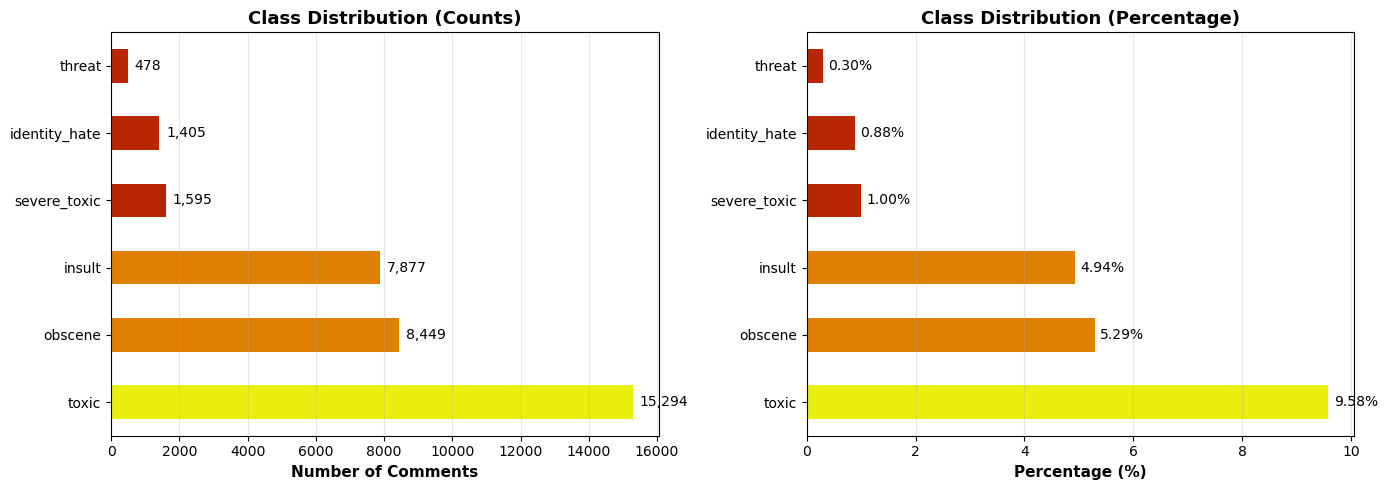

Class Summary
Label                       Count   Percentage       Imbalance
toxic                      15,294        9.58%            1:10
obscene                     8,449        5.29%            1:18
insult                      7,877        4.94%            1:20
severe_toxic                1,595        1.00%           1:100
identity_hate               1,405        0.88%           1:113
threat                        478        0.30%           1:333
Total Samples             159,571
Non-toxic Samples         143,346       89.83%
Toxic Samples              16,225       10.17%


In [3]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

counts = train_df[label_cols].sum().sort_values(ascending=False)
percentages = (counts / len(train_df)) * 100

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

#Plot 1: Class Distribution (Count)
colors = ['#eaf00e' if x > 10000 else '#e08002' if x > 5000 else '#b92602' for x in counts]
counts.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Number of Comments', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution (Counts)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, (label, value) in enumerate(counts.items()):
    ax1.text(value + 200, i, f'{value:,}', va='center', fontsize=10)
    
#Plot 2: Class Distribution (Percentages)
percentages.plot(kind='barh', ax=ax2, color=colors)
ax2.set_xlabel('Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Class Distribution (Percentage)', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (label, value) in enumerate(percentages.items()):
    ax2.text(value + 0.1, i, f'{value:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Class Summary")
print("="*80)
print(f"{'Label':<20} {'Count':>12} {'Percentage':>12} {'Imbalance':>15}")

for label in counts.index:
    count = counts[label]
    pct = percentages[label]
    ratio = int(len(train_df) / count)
    print(f"{label:<20} {count:>12,} {pct:>11.2f}% {'1:'+str(ratio):>15}")
print(f"{'Total Samples':<20} {len(train_df):>12,}")
print(f"{'Non-toxic Samples':<20} {(train_df[label_cols].sum(axis=1) == 0).sum():>12,} " + 
      f"{((train_df[label_cols].sum(axis=1) == 0).sum()/len(train_df)*100):>11.2f}%")
print(f"{'Toxic Samples':<20} {(train_df[label_cols].sum(axis=1) >0).sum():>12,} " + 
      f"{((train_df[label_cols].sum(axis=1) >0).sum()/len(train_df)*100):>11.2f}%")

### Before we begin building our models lets consider some naive approaches for classification
-----
If our models can outperform these naive approaches that means we have learned something meaningful about the data.

* Naive Strategy 1: Awlays Predict 'Not Toxic'
* Naive Strategy 2: Randomly Guess Based on Class Distribution
* Naive Strategy 3: Always Predict Toxic if Contains Profanity


In [4]:
print("Naive Approach #1: Always Predict Not Toxic")
print("-"*70)
print(f"{'Label':<20} {'Accuracy':>12}")

for label in label_cols: 
    accuracy = ((train_df[label] == 0).sum() / len(train_df)) * 100
    roc_auc = 0.5  
    print(f"{label:<20} {accuracy:>11.2f}%")

mean_accuracy = ((train_df[label_cols] == 0).sum().sum() / 
                 (len(train_df) * len(label_cols)) * 100)

print("-"*70)
print(f"{'Mean Accuracy':<20} {mean_accuracy:>11.2f}%")

print("\nNaive Approach #2: Random Guess Based on Class Distribution")
print("-"*70)
print(f"{'Label':<20} {'Exp Accuracy':>15}")

for label in label_cols:
    p = train_df[label].mean()  
    expected_accuracy = (p*p + (1-p)*(1-p)) * 100
    
    print(f"{label:<20} {expected_accuracy:>14.2f}%")

avg_expected_acc = (
    sum([(train_df[label].mean()**2 + (1 - train_df[label].mean())**2) for label in label_cols]) 
    / len(label_cols) * 100
)

print("-"*70)
print(f"{'Mean Expected Accuracy':<20} {avg_expected_acc:>14.2f}%")

print("\nNaive Approach #3: Look for Profanity, classify it as toxic")

url = 'https://www.cs.cmu.edu/~biglou/resources/bad-words.txt'
response = requests.get(url)
bad_words = set(response.text.lower().split('\n'))
bad_words = {word.strip() for word in bad_words if word.strip()}

def contains_profanity(text):
    text_lower = text.lower()
    words_in_text = set(text_lower.split())
    return 1 if (words_in_text & bad_words) else 0

train_df['keyword_prediction'] = train_df['comment_text'].apply(contains_profanity)

print(f"{'Label':<20} {'Accuracy':>12}")
print("-"*70)
accuracies = []
for label in label_cols:
    accuracy = (train_df[label] == train_df['keyword_prediction']).sum() / len(train_df) * 100
    accuracies.append(accuracy)
    print(f"{label:<20} {accuracy:>11.2f}%")
mean_accuracy_keyword = np.mean(accuracies)
print("-"*70)
print(f"{'Mean Accuracy':<20} {mean_accuracy_keyword:>11.2f}%")

Naive Approach #1: Always Predict Not Toxic
----------------------------------------------------------------------
Label                    Accuracy
toxic                      90.42%
severe_toxic               99.00%
obscene                    94.71%
threat                     99.70%
insult                     95.06%
identity_hate              99.12%
----------------------------------------------------------------------
Mean Accuracy              96.33%

Naive Approach #2: Random Guess Based on Class Distribution
----------------------------------------------------------------------
Label                   Exp Accuracy
toxic                         82.67%
severe_toxic                  98.02%
obscene                       89.97%
threat                        99.40%
insult                        90.61%
identity_hate                 98.25%
----------------------------------------------------------------------
Mean Expected Accuracy          93.16%

Naive Approach #3: Look for Profanity, c

### Discusion
Naive Approach #1 performed the best at 96.33% accuracy, however is a very bad model. As it is much more likely for a comment to not be toxic, purely guessing not toxic will equate to being correct most of the time. However when doing this we do no learning.

Naive Approach #2: Randomly guessing based on class distribution gives us 93$ accuracy. As there is a very unlikely chance for a comment to be a threat, severe_toxic, or identity_hate these were very accurate. However, more commonly seen comments including toxic and obscene comments were less accurate.

Naive Approach #3: If we purely classify a comment as toxic given if it contains a profanity performed the worst. However, using this as a preprocessing step and used in a more complex model will allow us to better model our data and get more accurate results.

In [5]:
# Do not include in the report
train_df['total_labels'] = train_df[label_cols].sum(axis=1)

most_toxic = train_df.nlargest(30, 'total_labels')

for idx, (i, row) in enumerate(most_toxic.iterrows(), 1):
    active_labels = [label for label in label_cols if row[label] == 1]
   # print(f"Labels: {', '.join(active_labels)}")
    comment = row['comment_text']
    #print(f"Text: {comment[:500]}")
    #print()



Logistic Regression Accuracy
Label                Accuracy (%)
--------------------------------------------------
toxic                       92.54
severe_toxic                99.35
obscene                     96.05
threat                      99.52
insult                      95.80
identity_hate               98.78
--------------------------------------------------
Mean accuracy: 97.0052%


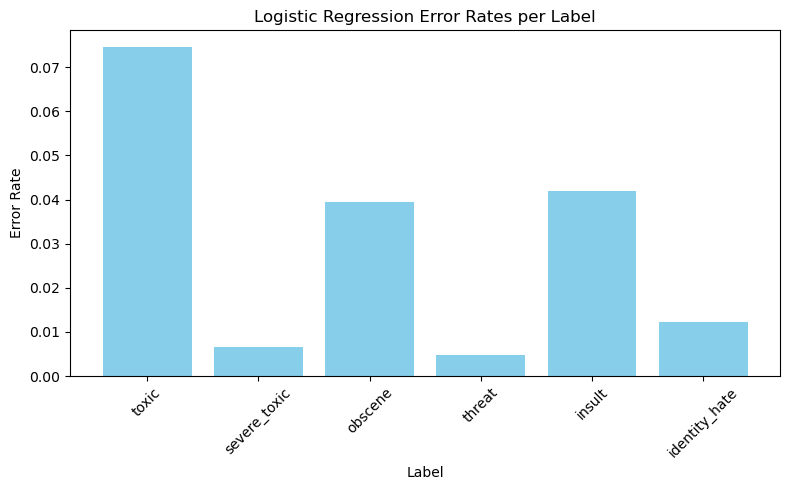

In [6]:
X_train = train_df['comment_text'].fillna('')
y_train = train_df[label_cols]
test_df_merged = test_df.merge(test_labels_df, on='id')
test_df_merged = test_df_merged[test_df_merged[label_cols].ge(0).all(axis=1)]
X_test = test_df_merged['comment_text'].fillna('')
y_test = test_df_merged[label_cols]
vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
models = {}
predictions_test = {}
errors = []
print("\nLogistic Regression Accuracy")
print("=" * 50)
print(f"{'Label':<20} {'Accuracy (%)':>12}")
print("-" * 50)
mean_accuracy = 0
for label in label_cols:
    model = LogisticRegression(C=1.0, max_iter=1000)
    model.fit(X_train_vec, y_train[label])

    models[label] = model
    predictions_test[label] = model.predict(X_test_vec)

    acc = accuracy_score(y_test[label], predictions_test[label]) * 100
    mean_accuracy += acc
    errors.append(1 - acc/100)

    print(f"{label:<20} {acc:>12.2f}")
print("-" * 50)
print(f"Mean accuracy: {mean_accuracy/6:.4f}%")
plt.figure(figsize=(8, 5))
plt.bar(label_cols, errors, color='skyblue')
plt.ylabel("Error Rate")
plt.xlabel("Label")
plt.title("Logistic Regression Error Rates per Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Discusion

With a mean accuracy of 97% this is better than our naive approach of always guessing non toxic.

### Cluster Boosting

Cluster Boosting Hyperparameter Tuning

Testing: n_clusters=3, features=3000, C=1.0
Mean Accuracy: 0.9742
Mean F1: 0.5011

Testing: n_clusters=5, features=3000, C=1.0
Mean Accuracy: 0.9742
Mean F1: 0.5011

Testing: n_clusters=5, features=5000, C=1.0
Mean Accuracy: 0.9745
Mean F1: 0.5090

Testing: n_clusters=7, features=3000, C=1.0
Mean Accuracy: 0.9742
Mean F1: 0.5011

Testing: n_clusters=5, features=3000, C=10.0
Mean Accuracy: 0.9727
Mean F1: 0.5289

BEST OVERALL CONFIGURATION
n_clusters: 5
features_per_cluster: 5000
C: 1.0
Mean Accuracy: 0.9745
Mean F1: 0.5090

BEST RESULTS PER LABEL
Label             Accuracy         F1   n_clusters   features
--------------------------------------------------------------------------------
toxic               0.9346     0.6714            5       5000
severe_toxic        0.9931     0.3496            3       3000
obscene             0.9673     0.6868            5       5000
threat              0.9966     0.3463            5       5000
insult          

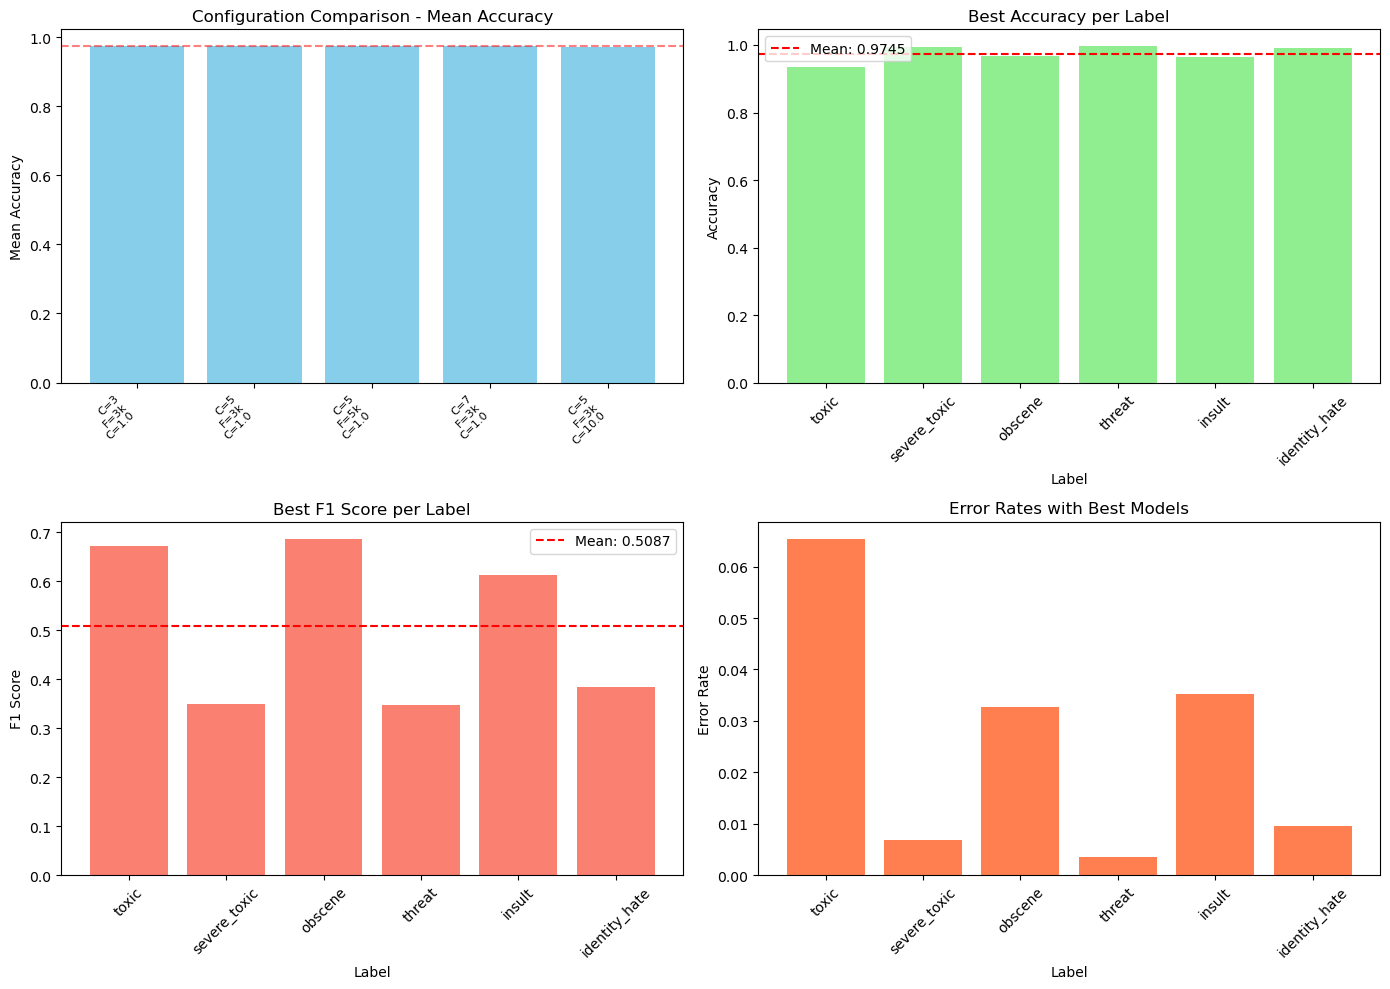


RECOMMENDATION
Use n_clusters=5, features_per_cluster=5000, C=1.0


In [7]:
param_combinations = [
    {'n_clusters': 3, 'features_per_cluster': 3000, 'C': 1.0},
    {'n_clusters': 5, 'features_per_cluster': 3000, 'C': 1.0},
    {'n_clusters': 5, 'features_per_cluster': 5000, 'C': 1.0},
    {'n_clusters': 7, 'features_per_cluster': 3000, 'C': 1.0},
    {'n_clusters': 5, 'features_per_cluster': 3000, 'C': 10.0},
]

best_results = {}
all_results = []

print("Cluster Boosting Hyperparameter Tuning")
print("=" * 80)

for params in param_combinations:
    n_clusters = params['n_clusters']
    features_per_cluster = params['features_per_cluster']
    C = params['C']
    
    print(f"\n{'='*80}")
    print(f"Testing: n_clusters={n_clusters}, features={features_per_cluster}, C={C}")
    print(f"{'='*80}")
    
    vectorizers = []
    for i in range(n_clusters):
        vec = TfidfVectorizer(
            max_features=features_per_cluster,
            ngram_range=(1, 1),
            min_df=3,
            max_df=0.9
        )
        vectorizers.append(vec)
    
    X_train_clusters = [vec.fit_transform(X_train) for vec in vectorizers]
    X_test_clusters = [vec.transform(X_test) for vec in vectorizers]
    
    predictions_test = {}
    label_accuracies = []
    label_f1s = []
    
    for label in label_cols:
        cluster_predictions = []
        
        for i in range(n_clusters):
            model = LogisticRegression(C=C, max_iter=1000, solver='saga')
            model.fit(X_train_clusters[i], y_train[label])
            pred_proba = model.predict_proba(X_test_clusters[i])[:, 1]
            cluster_predictions.append(pred_proba)
        
        avg_predictions = np.mean(cluster_predictions, axis=0)
        final_predictions = (avg_predictions >= 0.5).astype(int)
        
        predictions_test[label] = final_predictions
        
        acc = accuracy_score(y_test[label], final_predictions)
        f1 = f1_score(y_test[label], final_predictions)
        
        label_accuracies.append(acc)
        label_f1s.append(f1)
    
    mean_accuracy = np.mean(label_accuracies)
    mean_f1 = np.mean(label_f1s)
    
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Mean F1: {mean_f1:.4f}")
    
    # Store results
    result = {
        'params': params,
        'mean_accuracy': mean_accuracy,
        'mean_f1': mean_f1,
        'label_accuracies': label_accuracies,
        'label_f1s': label_f1s,
        'predictions': predictions_test
    }
    all_results.append(result)
    
    # Track best configuration per label
    for i, label in enumerate(label_cols):
        if label not in best_results or label_accuracies[i] > best_results[label]['accuracy']:
            best_results[label] = {
                'accuracy': label_accuracies[i],
                'f1': label_f1s[i],
                'params': params,
                'predictions': final_predictions
            }

best_config = max(all_results, key=lambda x: x['mean_accuracy'])

print("\n" + "=" * 80)
print("BEST OVERALL CONFIGURATION")
print("=" * 80)
print(f"n_clusters: {best_config['params']['n_clusters']}")
print(f"features_per_cluster: {best_config['params']['features_per_cluster']}")
print(f"C: {best_config['params']['C']}")
print(f"Mean Accuracy: {best_config['mean_accuracy']:.4f}")
print(f"Mean F1: {best_config['mean_f1']:.4f}")

print("\n" + "=" * 80)
print("BEST RESULTS PER LABEL")
print("=" * 80)
print(f"{'Label':<15} {'Accuracy':>10} {'F1':>10} {'n_clusters':>12} {'features':>10}")
print("-" * 80)

for label in label_cols:
    result = best_results[label]
    print(f"{label:<15} {result['accuracy']:>10.4f} {result['f1']:>10.4f} "
          f"{result['params']['n_clusters']:>12} {result['params']['features_per_cluster']:>10}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

config_labels = [f"C={r['params']['n_clusters']}\nF={r['params']['features_per_cluster']//1000}k\nC={r['params']['C']}" 
                 for r in all_results]
mean_accs = [r['mean_accuracy'] for r in all_results]
axes[0, 0].bar(range(len(all_results)), mean_accs, color='skyblue')
axes[0, 0].set_xticks(range(len(all_results)))
axes[0, 0].set_xticklabels(config_labels, rotation=45, ha='right', fontsize=8)
axes[0, 0].set_ylabel("Mean Accuracy")
axes[0, 0].set_title("Configuration Comparison - Mean Accuracy")
axes[0, 0].axhline(y=max(mean_accs), color='r', linestyle='--', alpha=0.5)

best_accuracies = [best_results[label]['accuracy'] for label in label_cols]
axes[0, 1].bar(label_cols, best_accuracies, color='lightgreen')
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].set_xlabel("Label")
axes[0, 1].set_title("Best Accuracy per Label")
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].axhline(y=np.mean(best_accuracies), color='r', linestyle='--',
                   label=f'Mean: {np.mean(best_accuracies):.4f}')
axes[0, 1].legend()

# Best configuration per label - F1 Score
best_f1s = [best_results[label]['f1'] for label in label_cols]
axes[1, 0].bar(label_cols, best_f1s, color='salmon')
axes[1, 0].set_ylabel("F1 Score")
axes[1, 0].set_xlabel("Label")
axes[1, 0].set_title("Best F1 Score per Label")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=np.mean(best_f1s), color='r', linestyle='--',
                   label=f'Mean: {np.mean(best_f1s):.4f}')
axes[1, 0].legend()

# Error rates with best configuration
errors = [1 - best_results[label]['accuracy'] for label in label_cols]
axes[1, 1].bar(label_cols, errors, color='coral')
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].set_xlabel("Label")
axes[1, 1].set_title("Error Rates with Best Models")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("RECOMMENDATION")
print("=" * 80)
print(f"Use n_clusters={best_config['params']['n_clusters']}, "
      f"features_per_cluster={best_config['params']['features_per_cluster']}, "
      f"C={best_config['params']['C']}")

### Discusion 

This slightly improves our model to 97.45% accuracy. We do hyperparameter tuning with number of clusters, features per cluster, and the regularization strength C. 

Tokenizing text...
Oversampling minority classes...

Class distribution before oversampling:
  toxic          : 0.0958 (15294 positive)
  severe_toxic   : 0.0100 (1595 positive)
  obscene        : 0.0529 (8449 positive)
  threat         : 0.0030 (478 positive)
  insult         : 0.0494 (7877 positive)
  identity_hate  : 0.0088 (1405 positive)

Class distribution after oversampling:
  toxic          : 0.1320 (21986 positive)
  severe_toxic   : 0.0338 (5635 positive)
  obscene        : 0.0850 (14149 positive)
  threat         : 0.0111 (1854 positive)
  insult         : 0.0814 (13553 positive)
  identity_hate  : 0.0302 (5037 positive)
Training samples after oversampling: 166527
Test samples: 63978

Building and training model...


I0000 00:00:1765485558.741806     559 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:2b:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 150, 64)   │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 150, 64)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 150, 64)   │     18,816 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 150, 1)    │         65 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 150)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 150)       │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 64, 150)   │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 150, 64)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 150, 64)   │          0 │ bidirectional[0]… │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        198 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 673,511 (2.57 MB)

 Trainable params: 673,511 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-12-11 12:39:21.681215: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


586/586 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.8313 - loss: 0.1776 - val_accuracy: 0.9813 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9628 - loss: 0.0986 - val_accuracy: 0.9813 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.9788 - loss: 0.0902 - val_accuracy: 0.9813 - val_loss: 0.4995 - learning_rate: 0.0010
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9835 - loss: 0.0842 - val_accuracy: 0.9813 - val_loss: 0.5080 - learning_rate: 0.0010
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.9843 - loss: 0.0787 - val_accuracy: 0.9813 - val_loss: 0.4619 - learning_rate: 0.0010
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.9771 - loss: 0.0730 - val_accuracy: 0.9813 - val_loss: 0.4440 - learning_rate: 0.0010
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.9706 - loss: 0.0683

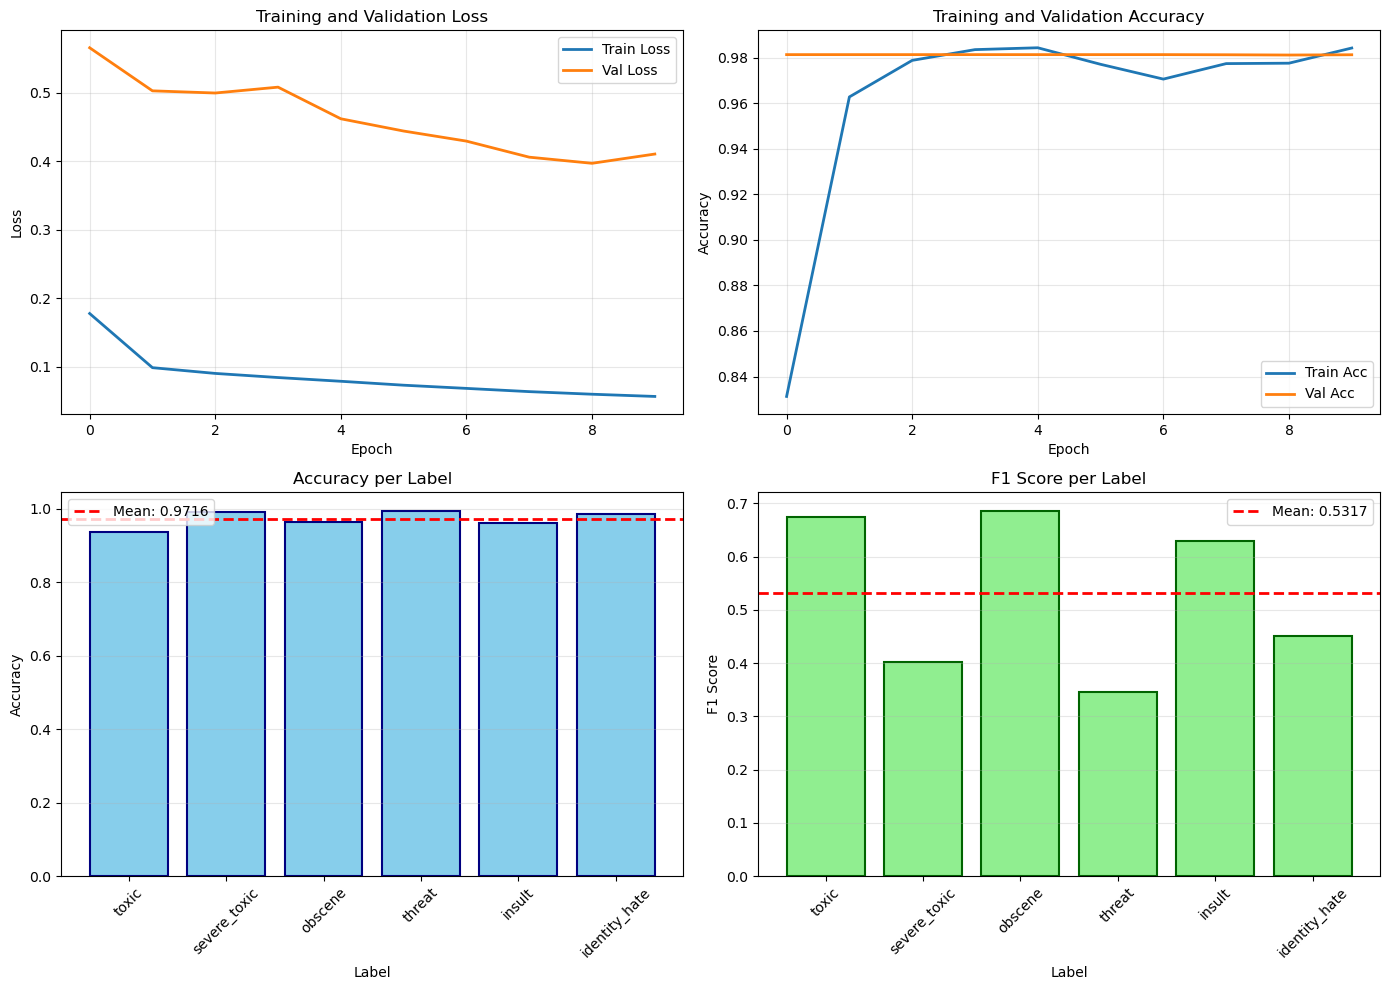

In [8]:
X_train = train_df['comment_text'].fillna('').values
y_train = train_df[label_cols].values
test_df_merged = test_df.merge(test_labels_df, on='id')
test_df_merged = test_df_merged[test_df_merged[label_cols].ge(0).all(axis=1)]
X_test = test_df_merged['comment_text'].fillna('').values
y_test = test_df_merged[label_cols].values

MAX_FEATURES = 10000
MAX_LEN = 150
EMBEDDING_DIM = 64

print("Tokenizing text...")
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

def oversample_minority_classes(X, y, max_ratio=0.05, max_oversample=3):
    X_resampled = list(X)
    y_resampled = list(y)
    
    print("\nClass distribution before oversampling:")
    for i in range(y.shape[1]):
        positive_ratio = y[:, i].sum() / len(y)
        print(f"  {label_cols[i]:<15}: {positive_ratio:.4f} ({int(y[:, i].sum())} positive)")
    
    for i in range(y.shape[1]):
        positive_ratio = y[:, i].sum() / len(y)
        if positive_ratio < max_ratio:
            positive_indices = np.where(y[:, i] == 1)[0]
            oversample_factor = min(int(max_ratio / positive_ratio), max_oversample)
            for _ in range(oversample_factor - 1):
                for idx in positive_indices:
                    X_resampled.append(X[idx])
                    y_resampled.append(y[idx])
    
    X_resampled = np.array(X_resampled)
    y_resampled = np.array(y_resampled)
    
    print("\nClass distribution after oversampling:")
    for i in range(y_resampled.shape[1]):
        positive_ratio = y_resampled[:, i].sum() / len(y_resampled)
        print(f"  {label_cols[i]:<15}: {positive_ratio:.4f} ({int(y_resampled[:, i].sum())} positive)")
    
    return X_resampled, y_resampled

print("Oversampling minority classes...")
X_train_pad, y_train = oversample_minority_classes(X_train_pad, y_train)

print(f"Training samples after oversampling: {len(X_train_pad)}")
print(f"Test samples: {len(X_test_pad)}")

def weighted_binary_crossentropy(pos_weight=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss_pos = -y_true * K.log(y_pred) * pos_weight
        loss_neg = -(1 - y_true) * K.log(1 - y_pred)
        return K.mean(loss_pos + loss_neg)
    return loss

def build_improved_model():
    inp = Input(shape=(MAX_LEN,))
    
    x = Embedding(MAX_FEATURES, EMBEDDING_DIM)(inp)
    x = SpatialDropout1D(0.2)(x)
    
    x = Bidirectional(GRU(32, return_sequences=True))(x)
    
    attention = Dense(1, activation='tanh')(x)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(64)(attention)
    attention = Permute([2, 1])(attention)
    
    x_attention = Multiply()([x, attention])
    x_attention = Lambda(lambda xin: K.sum(xin, axis=1))(x_attention)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = Concatenate()([x_attention, avg_pool, max_pool])
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    output = Dense(6, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=output)
    model.compile(
        loss=weighted_binary_crossentropy(pos_weight=3.0),
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

print("\nBuilding and training model...")
print("=" * 80)

model = build_improved_model()
model.summary()

history = model.fit(
    X_train_pad,
    y_train,
    batch_size=256,
    epochs=10,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nMaking predictions...")
y_pred_proba = model.predict(X_test_pad, batch_size=256)

print("\nFinding optimal thresholds...")
optimal_thresholds = []
for i in range(len(label_cols)):
    if y_pred_proba[:, i].max() < 0.01:
        optimal_thresholds.append(0.3)
        print(f"{label_cols[i]:<15}: 0.3000 (default - low predictions)")
        continue
    
    precision, recall, thresholds = precision_recall_curve(
        y_test[:, i], 
        y_pred_proba[:, i]
    )
    
    f1_scores_threshold = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores_threshold)
    
    if optimal_idx < len(thresholds):
        optimal_threshold = thresholds[optimal_idx]
        optimal_threshold = np.clip(optimal_threshold, 0.1, 0.9)
    else:
        optimal_threshold = 0.5
    
    optimal_thresholds.append(optimal_threshold)
    print(f"{label_cols[i]:<15}: {optimal_threshold:.4f}")

y_pred = np.zeros_like(y_pred_proba)
for i in range(len(label_cols)):
    y_pred[:, i] = (y_pred_proba[:, i] >= optimal_thresholds[i]).astype(int)

print("\n" + "=" * 80)
print("RESULTS PER LABEL (with optimized thresholds)")
print("=" * 80)
print(f"{'Label':<15} {'Threshold':>10} {'Accuracy':>10} {'F1':>10}")
print("-" * 80)

results = {}
mean_accuracy = 0
mean_f1 = 0

for i, label in enumerate(label_cols):
    accuracy = accuracy_score(y_test[:, i], y_pred[:, i])
    f1 = f1_score(y_test[:, i], y_pred[:, i])
    
    results[label] = {
        'accuracy': accuracy,
        'f1': f1,
        'threshold': optimal_thresholds[i]
    }
    
    mean_accuracy += accuracy
    mean_f1 += f1
    
    print(f"{label:<15} {optimal_thresholds[i]:>10.4f} {accuracy:>10.4f} {f1:>10.4f}")

print("-" * 80)
print(f"Mean Accuracy: {mean_accuracy/len(label_cols):.4f}")
print(f"Mean F1: {mean_f1/len(label_cols):.4f}")

y_pred_standard = (y_pred_proba >= 0.5).astype(int)
print("\n" + "=" * 80)
print("COMPARISON: Standard 0.5 threshold")
print("=" * 80)
print(f"{'Label':<15} {'Accuracy':>10} {'F1':>10}")
print("-" * 80)

mean_f1_standard = 0
for i, label in enumerate(label_cols):
    f1_standard = f1_score(y_test[:, i], y_pred_standard[:, i])
    mean_f1_standard += f1_standard
    print(f"{label:<15} {accuracy_score(y_test[:, i], y_pred_standard[:, i]):>10.4f} {f1_standard:>10.4f}")

print("-" * 80)
print(f"Mean F1 (0.5 threshold): {mean_f1_standard/len(label_cols):.4f}")
print(f"Mean F1 (optimized):     {mean_f1/len(label_cols):.4f}")
print(f"Improvement:             +{(mean_f1 - mean_f1_standard)/len(label_cols):.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

accuracies = [results[label]['accuracy'] for label in label_cols]
axes[1, 0].bar(label_cols, accuracies, color='skyblue', edgecolor='navy', linewidth=1.5)
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].set_xlabel("Label")
axes[1, 0].set_title("Accuracy per Label")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=np.mean(accuracies), color='r', linestyle='--',
                   label=f'Mean: {np.mean(accuracies):.4f}', linewidth=2)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

f1_scores = [results[label]['f1'] for label in label_cols]
axes[1, 1].bar(label_cols, f1_scores, color='lightgreen', edgecolor='darkgreen', linewidth=1.5)
axes[1, 1].set_ylabel("F1 Score")
axes[1, 1].set_xlabel("Label")
axes[1, 1].set_title("F1 Score per Label")
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=np.mean(f1_scores), color='r', linestyle='--',
                   label=f'Mean: {np.mean(f1_scores):.4f}', linewidth=2)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


CNN Model with Hyperparameter Tuning

We now implement a 1D Convolutional Neural Network (CNN) for text classification. CNNs can capture local n-gram patterns through convolution filters. We perform hyperparameter tuning over embedding dimension, number of filters, filter sizes, and dropout rate.

CNN Hyperparameter Tuning

[1/4] Testing: {'embedding_dim': 64, 'num_filters': 64, 'filter_sizes': [3, 4, 5], 'dropout_rate': 0.3}
------------------------------------------------------------------------------------------
Epoch 1/5


2025-12-11 12:43:07.345274: I external/local_xla/xla/service/service.cc:163] XLA service 0x7343bc00af50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-11 12:43:07.345296: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-11 12:43:07.386952: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-11 12:43:07.777011: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:43:07.777068: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because

 22/586 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0614 - loss: 0.5078

2025-12-11 12:43:12.258786: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_91', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1765485792.272409     695 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


585/586 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4861 - loss: 0.1622

2025-12-11 12:43:16.828089: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:43:16.828146: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:43:16.828159: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:43:17.341889: I external/l

586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4864 - loss: 0.1621

2025-12-11 12:43:21.311712: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_91', 4 bytes spill stores, 4 bytes spill loads



586/586 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6925 - loss: 0.0922 - val_accuracy: 0.9741 - val_loss: 0.3009
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9331 - loss: 0.0498 - val_accuracy: 0.9745 - val_loss: 0.2364
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9415 - loss: 0.0440 - val_accuracy: 0.9763 - val_loss: 0.2104
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9462 - loss: 0.0400 - val_accuracy: 0.9687 - val_loss: 0.1951
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9274 - loss: 0.0373 - val_accuracy: 0.9751 - val_loss: 0.1826
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-12-11 12:43:42.728670: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:43:43.243312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_100', 16 bytes spill stores, 16 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean Accuracy: 0.9706 | Mean F1: 0.5450

[2/4] Testing: {'embedding_dim': 128, 'num_filters': 128, 'filter_sizes': [3, 4, 5], 'dropout_rate': 0.5}
------------------------------------------------------------------------------------------
Epoch 1/5


2025-12-11 12:43:45.288933: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:43:45.801564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043', 116 bytes spill stores, 116 bytes spill loads



  5/586 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.6691 - loss: 0.9370

2025-12-11 12:43:49.164108: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_91', 4 bytes spill stores, 4 bytes spill loads



585/586 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6301 - loss: 0.2108

2025-12-11 12:43:59.676243: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:43:59.676285: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:44:00.081128: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043', 16 bytes spill stores, 16 bytes spill loads

2025-12-11 12:44:00.551464: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6303 - loss: 0.2107

2025-12-11 12:44:02.839143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_91', 4 bytes spill stores, 4 bytes spill loads



586/586 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7088 - loss: 0.1084 - val_accuracy: 0.9802 - val_loss: 0.2885
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8848 - loss: 0.0524 - val_accuracy: 0.9799 - val_loss: 0.2610
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9107 - loss: 0.0456 - val_accuracy: 0.9809 - val_loss: 0.2030
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9383 - loss: 0.0417 - val_accuracy: 0.9795 - val_loss: 0.1986
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9447 - loss: 0.0392 - val_accuracy: 0.9814 - val_loss: 0.1915
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Accuracy: 0.9682 | Mean F1: 0.5203

[3/4] Testing: {'embedding_dim': 128, 'num_filters': 128, 'filter_sizes': [2, 3, 4], 'dropout_rate': 0.5}
------------------------------------------------------------------------------------------
Epoch 1/5
  8/586 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.1000 - loss: 0.7373

2025-12-11 12:44:51.375053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_91', 4 bytes spill stores, 4 bytes spill loads



582/586 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4246 - loss: 0.1877

2025-12-11 12:45:01.291863: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4258 - loss: 0.1872

2025-12-11 12:45:03.586183: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_91', 4 bytes spill stores, 4 bytes spill loads



586/586 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.5998 - loss: 0.1022 - val_accuracy: 0.9789 - val_loss: 0.2813
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8632 - loss: 0.0515 - val_accuracy: 0.9780 - val_loss: 0.2312
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9242 - loss: 0.0457 - val_accuracy: 0.9792 - val_loss: 0.2180
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9369 - loss: 0.0421 - val_accuracy: 0.9800 - val_loss: 0.2000
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9398 - loss: 0.0397 - val_accuracy: 0.9808 - val_loss: 0.1995
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean Accuracy: 0.9712 | Mean F1: 0.5349

[4/4] Testing: {'embedding_dim': 128, 'num_filters': 256, 'filter_sizes': [3, 4, 5], 'dropout_rate': 0.5}
------------------------------------------------------------------------------------------
Epoch 1/5
  2/586 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.0537 - loss: 0.7509

2025-12-11 12:45:50.521288: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_91', 4 bytes spill stores, 4 bytes spill loads



584/586 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4985 - loss: 0.1585

2025-12-11 12:46:07.674955: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-11 12:46:08.048752: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043', 8 bytes spill stores, 8 bytes spill loads

2025-12-11 12:46:08.099446: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043', 16 bytes spill stores, 16 bytes spill loads

2025-12-11 12:46:08.158134: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2043', 548 byt

586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4992 - loss: 0.1583

2025-12-11 12:46:10.318825: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_91', 4 bytes spill stores, 4 bytes spill loads



586/586 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6907 - loss: 0.0900 - val_accuracy: 0.9790 - val_loss: 0.2884
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9041 - loss: 0.0494 - val_accuracy: 0.9794 - val_loss: 0.2298
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9250 - loss: 0.0437 - val_accuracy: 0.9787 - val_loss: 0.2021
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.9090 - loss: 0.0403 - val_accuracy: 0.9503 - val_loss: 0.2008
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.9117 - loss: 0.0371 - val_accuracy: 0.9768 - val_loss: 0.1844
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Mean Accuracy: 0.9696 | Mean F1: 0.5142

BEST CNN CONFIGURATION
Parameters: {'embedding_dim': 64, 'num_filters': 64, 'filter_sizes': [3, 4, 5], 'dropout_rate': 0.3}
Mean Accuracy: 0.9706
Mean F1 Score: 0.5450

PER-LABEL RESULTS (Best Config)
Label             Accuracy         F1
----------------------------------------
to

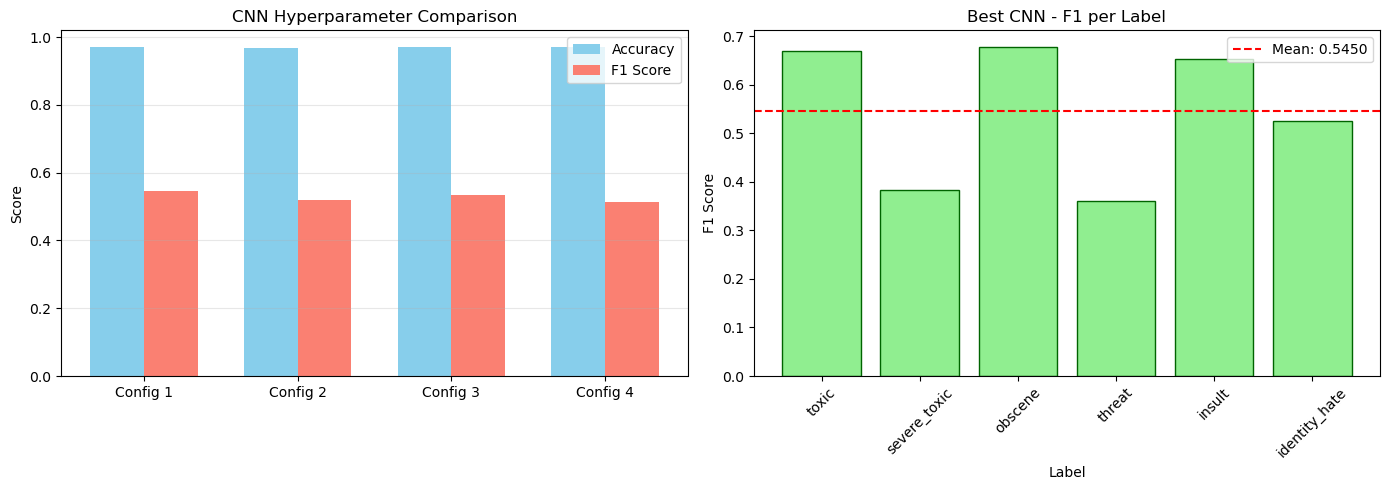

In [9]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization

def build_cnn_model(embedding_dim=128, num_filters=128, filter_sizes=[3, 4, 5], dropout_rate=0.5):
    inp = Input(shape=(MAX_LEN,))
    x = Embedding(MAX_FEATURES, embedding_dim)(inp)
    x = SpatialDropout1D(0.2)(x)
    
    conv_blocks = []
    for filter_size in filter_sizes:
        conv = Conv1D(num_filters, filter_size, activation='relu', padding='same')(x)
        conv = GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)
    
    x = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate / 2)(x)
    output = Dense(6, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

cnn_param_grid = [
    {'embedding_dim': 64, 'num_filters': 64, 'filter_sizes': [3, 4, 5], 'dropout_rate': 0.3},
    {'embedding_dim': 128, 'num_filters': 128, 'filter_sizes': [3, 4, 5], 'dropout_rate': 0.5},
    {'embedding_dim': 128, 'num_filters': 128, 'filter_sizes': [2, 3, 4], 'dropout_rate': 0.5},
    {'embedding_dim': 128, 'num_filters': 256, 'filter_sizes': [3, 4, 5], 'dropout_rate': 0.5},
]

cnn_results = []

print("CNN Hyperparameter Tuning")
print("=" * 90)

for idx, params in enumerate(cnn_param_grid):
    print(f"\n[{idx+1}/{len(cnn_param_grid)}] Testing: {params}")
    print("-" * 90)
    
    model = build_cnn_model(**params)
    
    history = model.fit(
        X_train_pad, y_train,
        batch_size=256,
        epochs=5,
        validation_split=0.1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
        verbose=1
    )
    
    y_pred_proba = model.predict(X_test_pad, batch_size=256)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    label_accuracies = []
    label_f1s = []
    for i, label in enumerate(label_cols):
        acc = accuracy_score(y_test[:, i], y_pred[:, i])
        f1 = f1_score(y_test[:, i], y_pred[:, i])
        label_accuracies.append(acc)
        label_f1s.append(f1)
    
    mean_acc = np.mean(label_accuracies)
    mean_f1 = np.mean(label_f1s)
    
    print(f"Mean Accuracy: {mean_acc:.4f} | Mean F1: {mean_f1:.4f}")
    
    cnn_results.append({
        'params': params,
        'mean_accuracy': mean_acc,
        'mean_f1': mean_f1,
        'label_accuracies': label_accuracies,
        'label_f1s': label_f1s
    })

best_cnn = max(cnn_results, key=lambda x: x['mean_f1'])

print("\n" + "=" * 90)
print("BEST CNN CONFIGURATION")
print("=" * 90)
print(f"Parameters: {best_cnn['params']}")
print(f"Mean Accuracy: {best_cnn['mean_accuracy']:.4f}")
print(f"Mean F1 Score: {best_cnn['mean_f1']:.4f}")

print("\n" + "=" * 90)
print("PER-LABEL RESULTS (Best Config)")
print("=" * 90)
print(f"{'Label':<15} {'Accuracy':>10} {'F1':>10}")
print("-" * 40)
for i, label in enumerate(label_cols):
    print(f"{label:<15} {best_cnn['label_accuracies'][i]:>10.4f} {best_cnn['label_f1s'][i]:>10.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

config_names = [f"Config {i+1}" for i in range(len(cnn_results))]
accs = [r['mean_accuracy'] for r in cnn_results]
f1s = [r['mean_f1'] for r in cnn_results]

x_pos = np.arange(len(cnn_results))
width = 0.35

axes[0].bar(x_pos - width/2, accs, width, label='Accuracy', color='skyblue')
axes[0].bar(x_pos + width/2, f1s, width, label='F1 Score', color='salmon')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(config_names)
axes[0].set_ylabel('Score')
axes[0].set_title('CNN Hyperparameter Comparison')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(label_cols, best_cnn['label_f1s'], color='lightgreen', edgecolor='darkgreen')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Label')
axes[1].set_title('Best CNN - F1 per Label')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=best_cnn['mean_f1'], color='r', linestyle='--', label=f"Mean: {best_cnn['mean_f1']:.4f}")
axes[1].legend()

plt.tight_layout()
plt.show()

For our “Something Extra,” we took inspiration from several winning approaches in the original Kaggle Toxic Comment Classification Challenge. Their strategies have been shown to produce highly accurate results, so we found it a good source to learn from.

We first tokenize the text by building a vocabulary of the 10,000 most frequent words in the training set. Since the dataset is highly imbalanced with around 89% non-toxic and only 11% toxic, models tend to learn that predicting zeros everywhere is good enough, which just defaults to our first naive approach. To address this imbalance, we oversample the rare toxic examples so the model has more opportunities to learn what toxic comments look like. We also apply class-weighted loss so that misclassifying toxic comments is penalized more heavily, preventing the model from collapsing into predicting only zeros.

After preprocessing, we build a neural network with an attention mechanism. The model converts token IDs into word-embedding vectors, then passes them through a Bidirectional GRU (a recurrent sequence model that reads text both forward and backward). This produces a richer set of hidden states for the attention layer to focus on. We also use standard training optimizations including early stopping (to halt training when validation loss stops improving) and a learning-rate reduction strategy when progress slows.

Unfortunately, the result was just 97.06% accurate worse than our optomized cluster boosting. As I am running this on a laptop, we could not make our model too complex running on a single GPU, but with a more complex model and better compute these methods have been proven by others to produce very accurate results, up to 98.9% accuracy on the same dataset.